In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/conditions_self_harm.db")

query = """
SELECT age, gender, patient
FROM (
         SELECT c.patient, p.gender, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
         FROM conditions c
                  JOIN patients p on c.patient = p.id
         WHERE c.description LIKE '%suicide%'
         GROUP BY c.patient
         ORDER BY age
     ) h;
"""

df = pd.read_sql(query, conn)

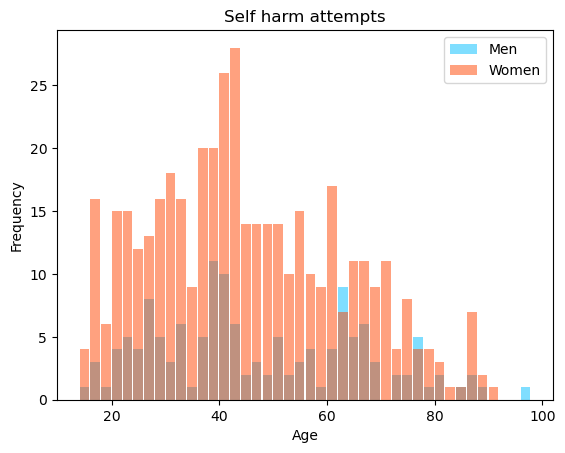

In [25]:
import matplotlib.pyplot as plt
wdf = df.where(df.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = df.where(df.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
x = wdf["age"]
y = wdf["patient"]
xmen = mdf["age"]
ymen = mdf["patient"]

plt.bar(xmen, ymen, width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(x, y, width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Self harm attempts')
plt.legend()
plt.show()

In [26]:
# Recurrent urinary tract infection

falseQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id NOT IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION LIKE '%suicide%'
);
"""
trueQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION LIKE '%suicide%'
);
"""

falsedf = pd.read_sql(falseQuery, conn)
truedf = pd.read_sql(trueQuery, conn)

In [55]:
import random
import math
import numpy as np
def eps(prob):
    return np.log(1/prob - 1)
    #reverse: p = 1 / (1 + math.exp(epsilon))

def randomizedResponse(true_answer, prob):
    if random.random() < prob:
        return true_answer
    else:
        return random.choice([True, False])

def rr(yesses, all):
    nos = all - yesses
    rand = 0

    for x in range(yesses):
        if randomizedResponse(True, 0.5):
            rand = rand + 1
    for x in range(nos):
        if randomizedResponse(False, 0.5):
            rand = rand + 1

    fakeYesses = all / 4
    return (rand - fakeYesses) * 2

In [38]:
wCounts = []
mCounts = []
for i in range(100):
    womenCount = rr(len(truedf.where(truedf.GENDER == 'F').dropna()), len(falsedf.where(falsedf.GENDER == 'F').dropna()))
    menCount = rr(len(truedf.where(truedf.GENDER == 'M').dropna()), len(falsedf.where(falsedf.GENDER == 'M').dropna()))
    wCounts.append(womenCount)
    mCounts.append(menCount)


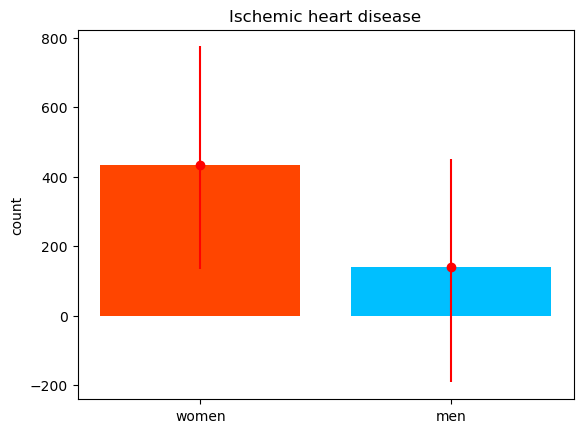

In [50]:
wc = len(truedf.where(truedf.GENDER == 'F').dropna())
mc = len(truedf.where(truedf.GENDER == 'M').dropna())

fig, ax = plt.subplots()

genders = ['women', 'men']
counts = [wc, mc]
bar_colors = ['orangered', 'deepskyblue']

ax.bar(genders, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('Self harm')
plt.errorbar(genders, counts, yerr=[[wc - min(wCounts), mc - min(mCounts)], [max(wCounts) - wc, max(mCounts) - mc]], fmt="o", color="r")

plt.show()

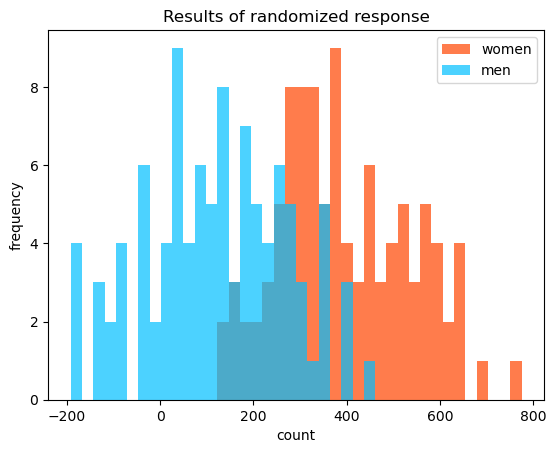

In [52]:
plt.cla()
bins=np.histogram(np.hstack((wCounts,mCounts)), bins=40)[1]
plt.hist(wCounts, bins, color='orangered', label='women', alpha=0.7)
plt.hist(mCounts, bins, color='deepskyblue', label='men', alpha=0.7)
plt.xlabel('count')
plt.ylabel('frequency')
plt.title('Results of randomized response')
plt.legend()
plt.show()

In [56]:
eps(0.5)

0.0